In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from PIL import Image
from skimage.io import imread
import cv2

warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

In [2]:
import shutil
def split_data(source_dir, train_dir, val_dir, test_dir, train_size=0.8, val_size=0.1, test_size=0.1):
    categories = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for category in categories:
        # Make new directories for training, validation, and testing within each category
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # Get all files in the current category
        files = os.listdir(os.path.join(source_dir, category))
        np.random.shuffle(files)  # Shuffle files to randomize

        # Split files according to provided ratios
        train_end = int(len(files) * train_size)
        val_end = train_end + int(len(files) * val_size)

        # Train files
        for f in files[:train_end]:
            shutil.copy(os.path.join(source_dir, category, f), os.path.join(train_dir, category, f))

        # Validation files
        for f in files[train_end:val_end]:
            shutil.copy(os.path.join(source_dir, category, f), os.path.join(val_dir, category, f))

        # Test files
        for f in files[val_end:]:
            shutil.copy(os.path.join(source_dir, category, f), os.path.join(test_dir, category, f))

In [3]:
# Define directories
source_dir = '/kaggle/input/dataset-food-classification/dataset_gambar'
train_dir = '/kaggle/working/dataset/train/'
valid_dir = '/kaggle/working/dataset/valid/'
test_dir = '/kaggle/working/dataset/test/'

In [4]:
# Ensure the target directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Apply the function to each category of images if needed
split_data(source_dir, train_dir, valid_dir, test_dir)

In [5]:
img = plt.imread('/kaggle/working/dataset/train/Burger/Burger_004.jpg')
dims = np.shape(img)
matrix = np.reshape(img, (dims[0] * dims[1], dims[2]))
print(np.shape(matrix))

(902144, 3)


Image shape ->  (881, 1024)
Color channels ->  3
Min color depth : 0, Max color depth 255


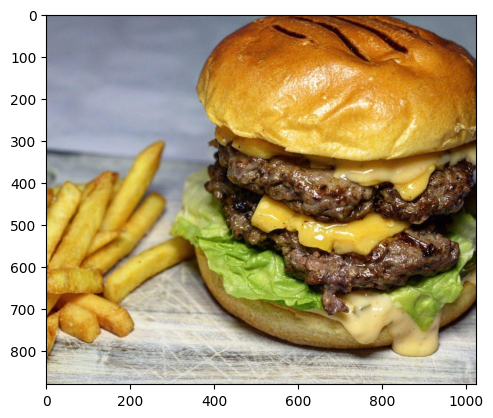

In [6]:
plt.imshow(img)
print("Image shape -> ",dims[:2])
print("Color channels -> ",dims[2])
print("Min color depth : {}, Max color depth {}".format(np.min(img),np.max(img)))

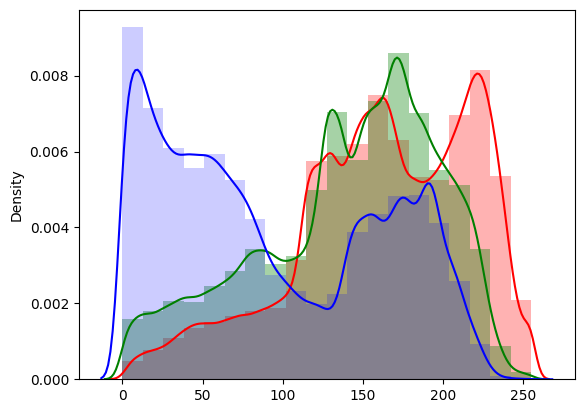

In [7]:
sns.distplot(matrix[:,0], bins=20,color="red",hist_kws=dict(alpha=0.3))
sns.distplot(matrix[:,1], bins=20,color="green",hist_kws=dict(alpha=0.35))
sns.distplot(matrix[:,2], bins=20,color="blue",hist_kws=dict(alpha=0.2))
plt.show()

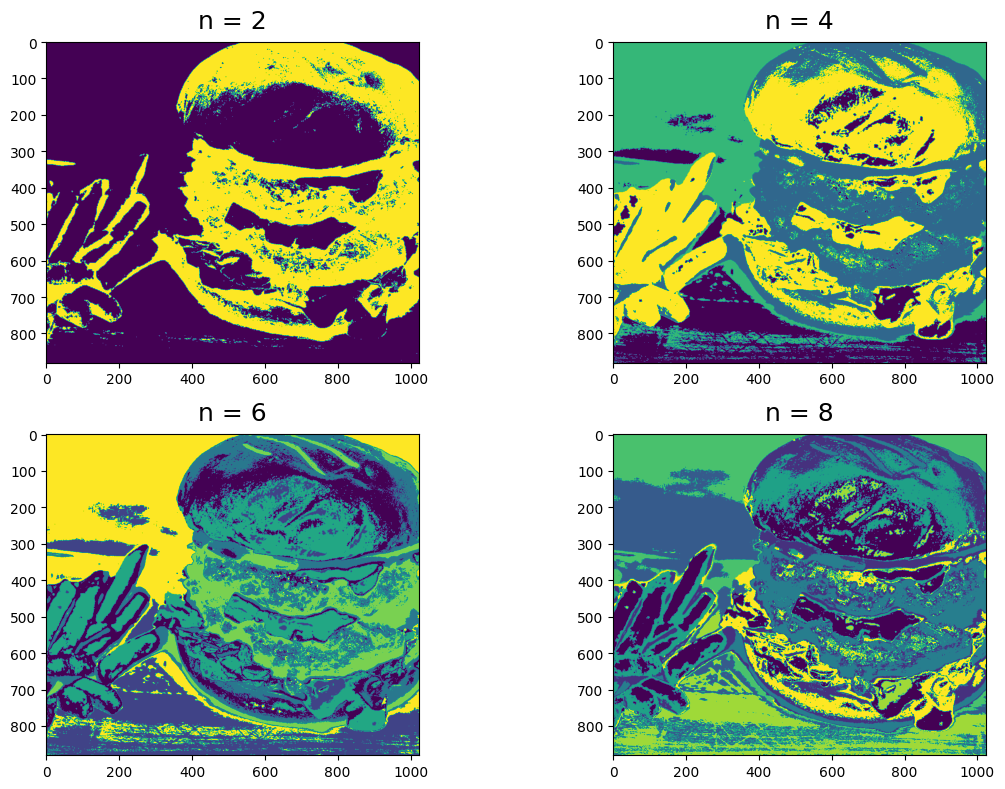

In [8]:
from sklearn import cluster
n_vals=[2,4,6,8]
plt.figure(1, figsize=(12, 8))

for subplot,n in enumerate(n_vals):
    kmeans=cluster.KMeans(n)
    clustered = kmeans.fit_predict(matrix)
    dims = np.shape(img)
    clustered_img = np.reshape(clustered, (dims[0], dims[1]))
    plt.subplot(2,2, subplot+1)
    plt.title("n = {}".format(n), pad = 10,size=18)
    plt.imshow(clustered_img)

plt.tight_layout()

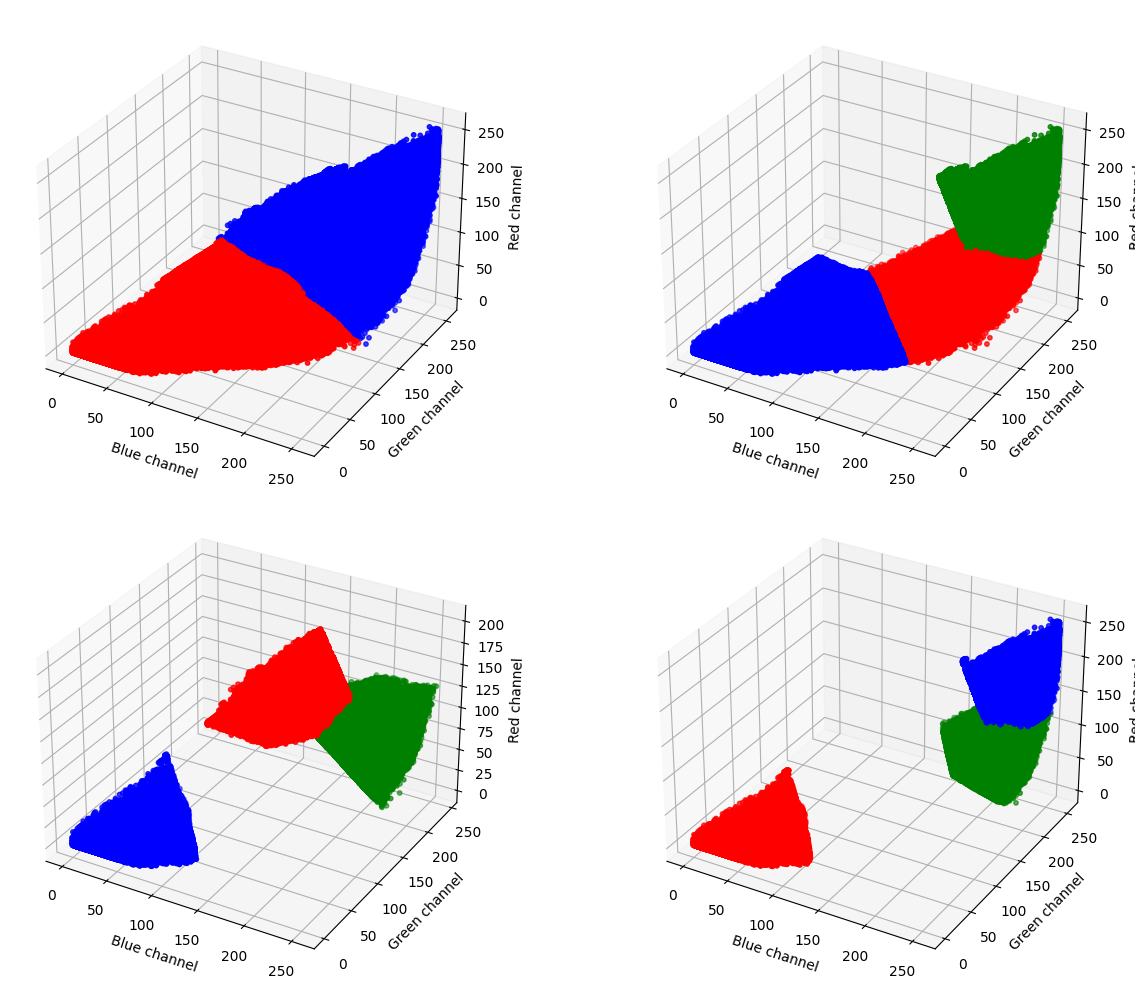

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure(figsize=(14,10))

ax = [fig.add_subplot(221, projection='3d'),
      fig.add_subplot(222, projection='3d'),
      fig.add_subplot(223, projection='3d'),
      fig.add_subplot(224, projection='3d')]

for plot_number,n in enumerate(n_vals):

    kmeans=cluster.KMeans(n)
    clustered = kmeans.fit_predict(matrix)
    x1, y1, z1 = [np.where(clustered == x)[0] for x in [0, 1, 2]]

    plot_vals = [('r', x1),
                 ('b', y1),
                 ('g', z1),
                 ]

    for c, channel in plot_vals:
        x = matrix[channel, 0]
        y = matrix[channel, 1]
        z = matrix[channel, 2]
        ax[plot_number].scatter(x, y, z, c=c,s=10)

    ax[plot_number].set_xlabel('Blue channel')
    ax[plot_number].set_ylabel('Green channel')
    ax[plot_number].set_zlabel('Red channel')

plt.tight_layout()

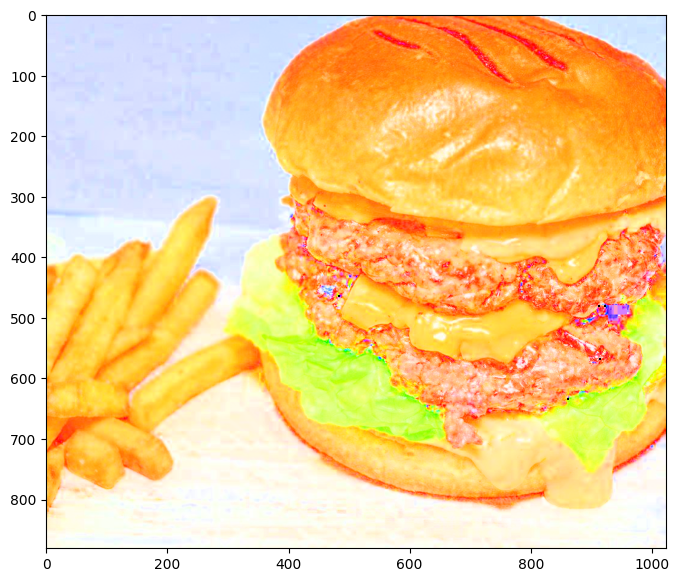

In [10]:
bnorm = np.zeros_like(matrix, dtype=np.float32)
max_range = np.max(matrix, axis=1)
bnorm = matrix / np.vstack((max_range, max_range, max_range)).T
bnorm_img = np.reshape(bnorm, (dims[0],dims[1],dims[2]))
plt.figure(figsize=(8,10))
plt.imshow(bnorm_img)
plt.show()

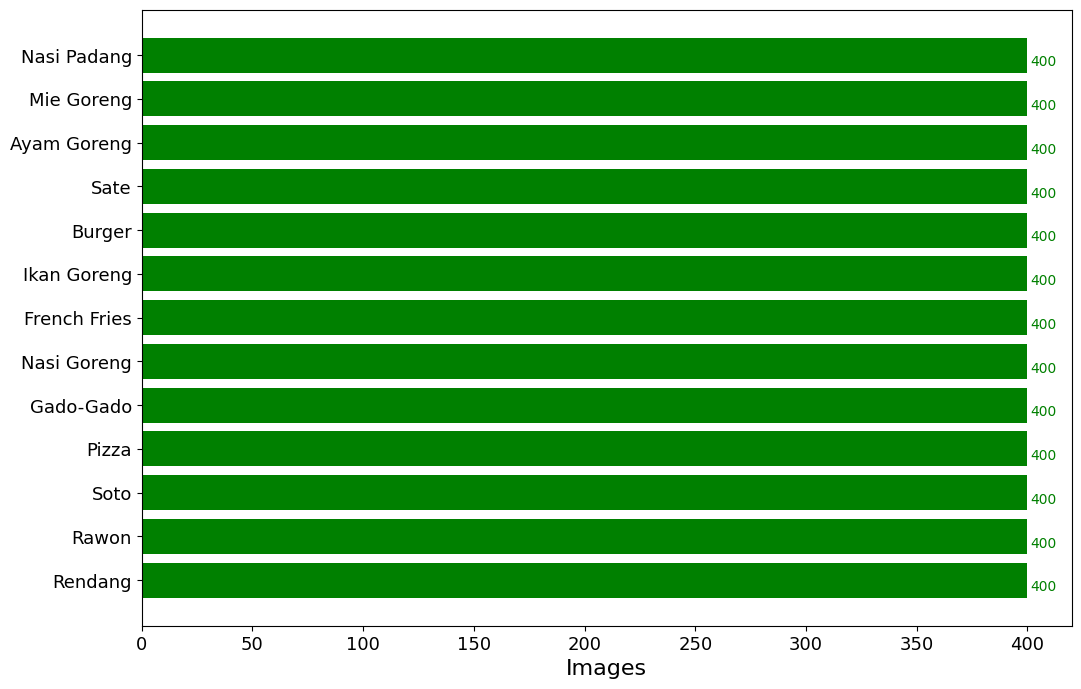

In [11]:
main='/kaggle/working/dataset/train'

data=dict()

for i in os.listdir(main):
    sub_dir=os.path.join(main,i)
    count=len(os.listdir(sub_dir))
    data[i]=count


keys = data.keys()
values = data.values()

colors=["red" if x<= 150 else "green" for x in values]

fig, ax = plt.subplots(figsize=(12,8))
y_pos=np.arange(len(values))
plt.barh(y_pos,values,align='center',color=colors)
for i, v in enumerate(values):
    ax.text(v+1.4, i-0.25, str(v), color=colors[i])
ax.set_yticks(y_pos)
ax.set_yticklabels(keys)
ax.set_xlabel('Images',fontsize=16)
plt.xticks(color='black',fontsize=13)
plt.yticks(fontsize=13)
plt.show()

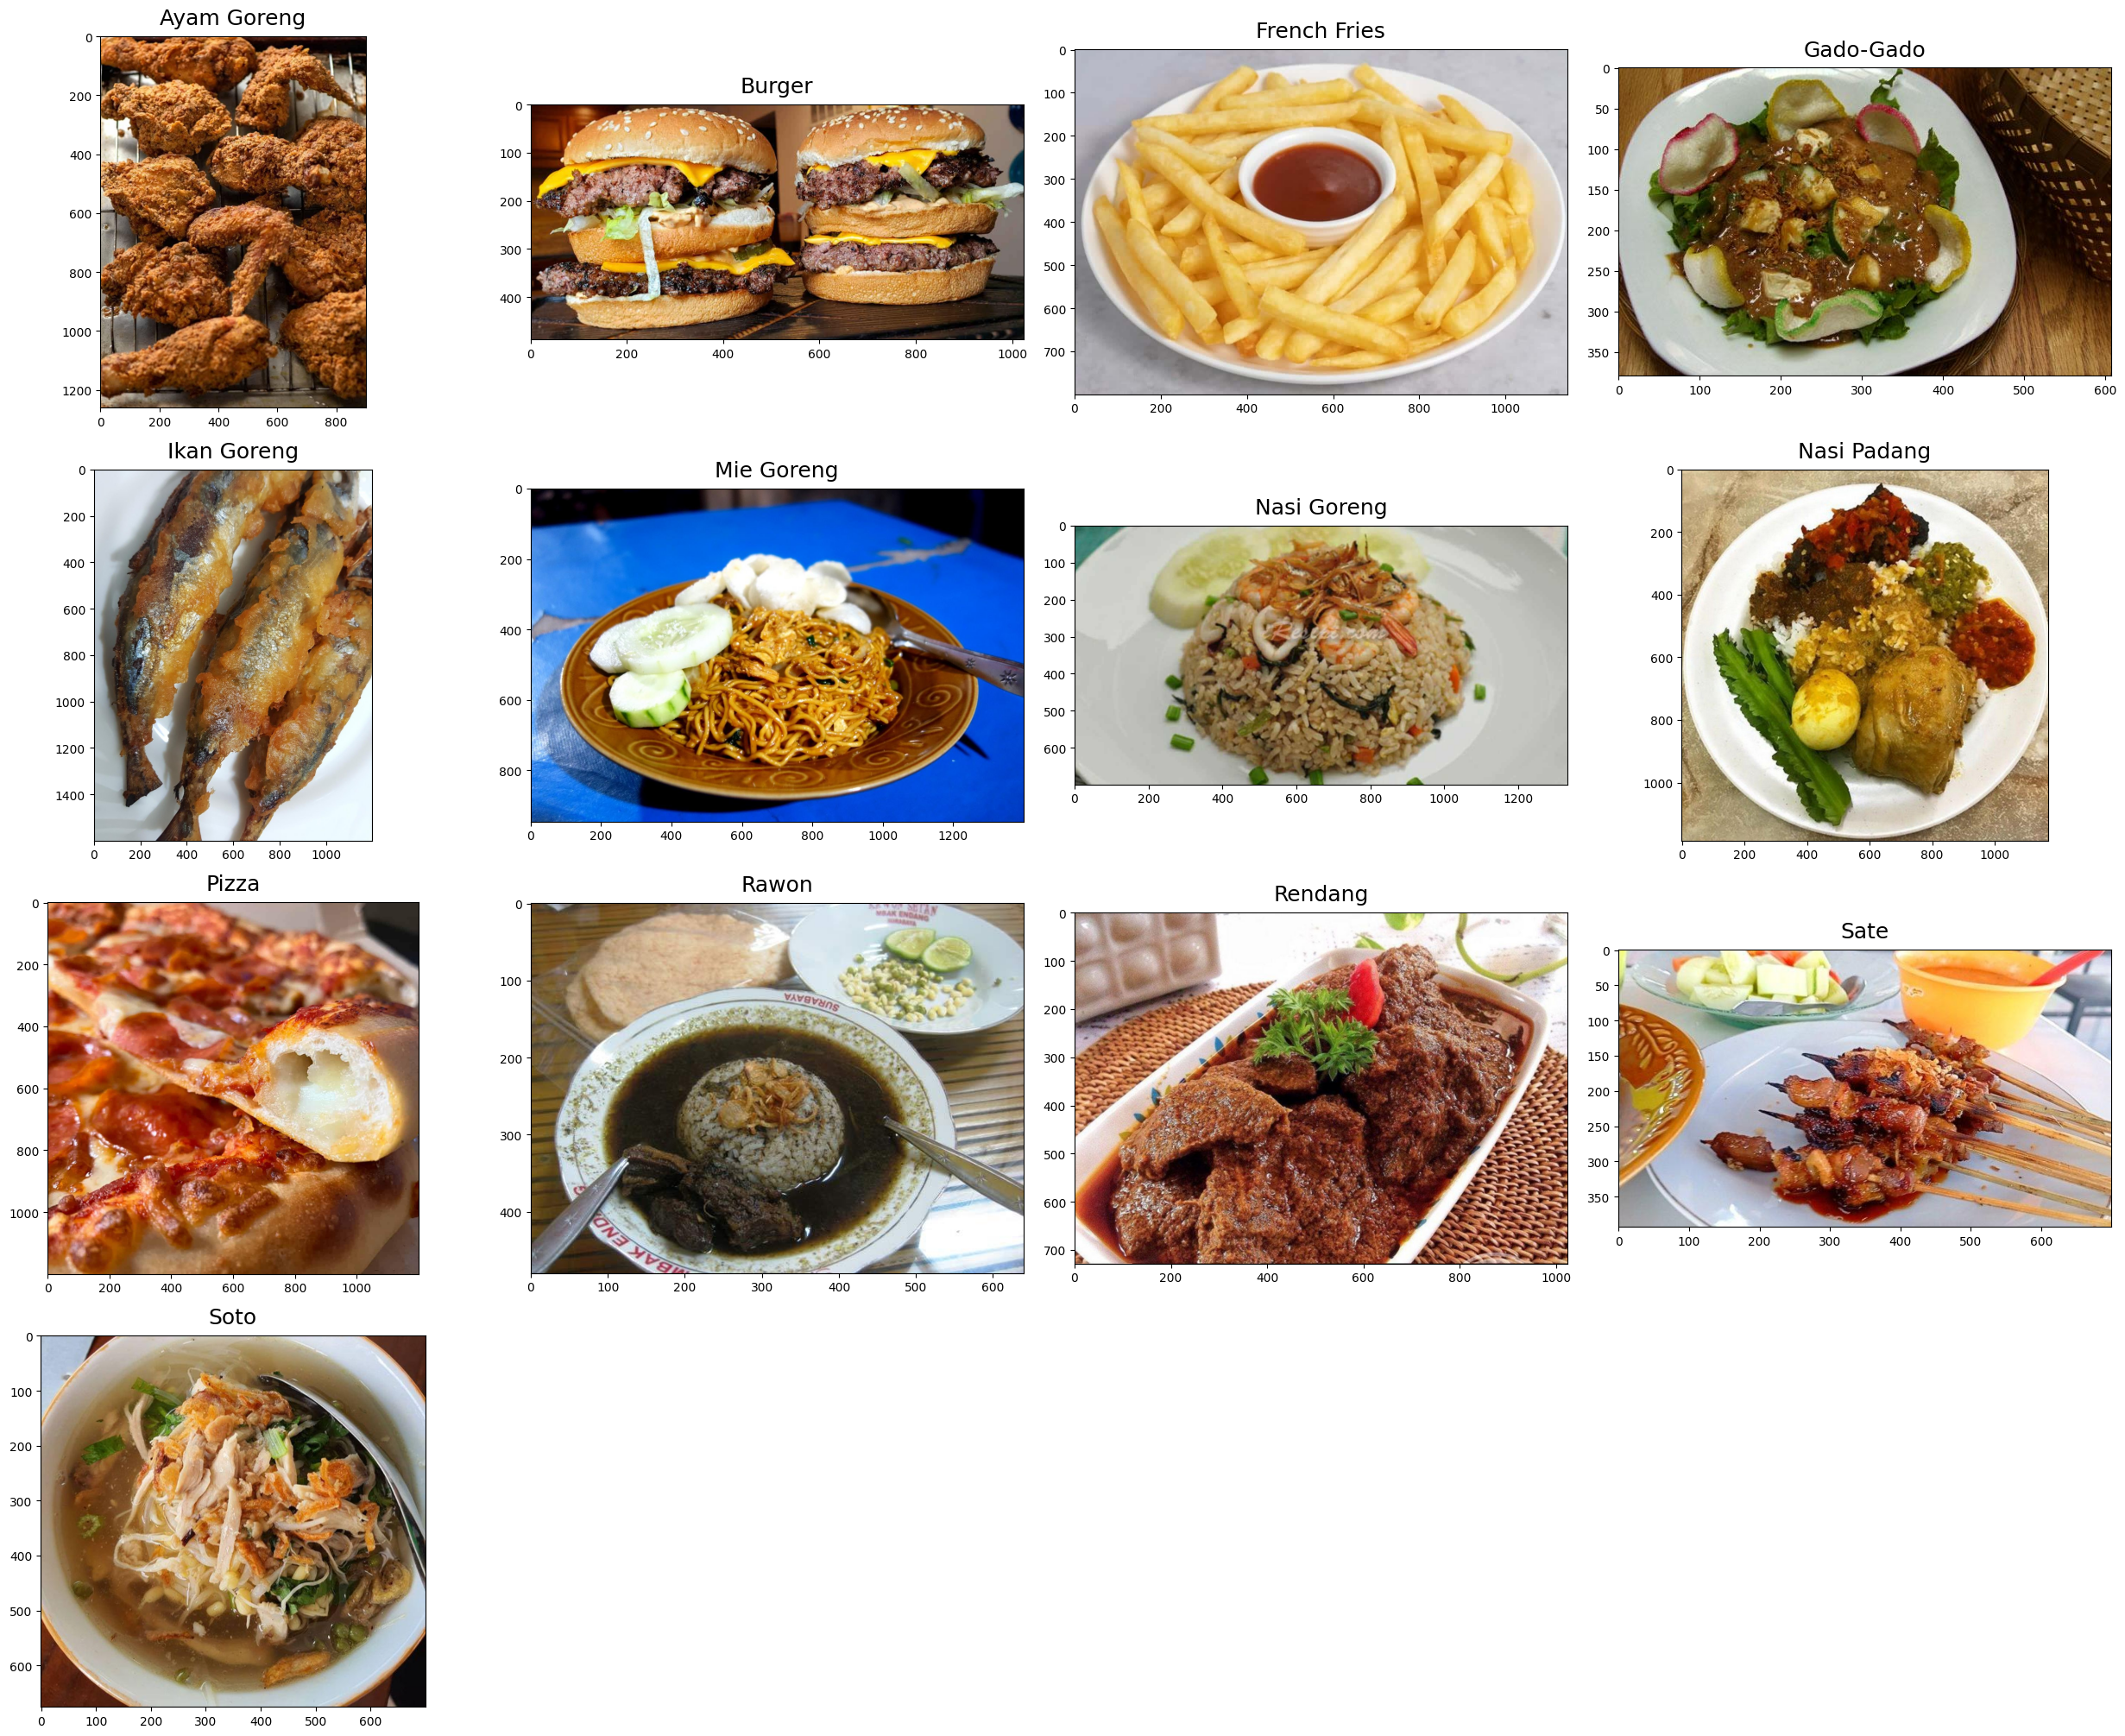

In [12]:
import random

train_folder = "/kaggle/working/dataset/train"
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))

fig=plt.figure(1, figsize=(25, 25))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(5, 4, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)

plt.tight_layout()

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

n_classes = 13
batch_size = 32
img_width, img_height = 299, 299

train_data_dir = '/kaggle/working/dataset/train'

# Data Augmentation with ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

val_data_dir = '/kaggle/working/dataset/valid'

val_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 5193 images belonging to 13 classes.
Found 648 images belonging to 13 classes.


In [14]:
class_map = train_generator.class_indices
class_map

{'Ayam Goreng': 0,
 'Burger': 1,
 'French Fries': 2,
 'Gado-Gado': 3,
 'Ikan Goreng': 4,
 'Mie Goreng': 5,
 'Nasi Goreng': 6,
 'Nasi Padang': 7,
 'Pizza': 8,
 'Rawon': 9,
 'Rendang': 10,
 'Sate': 11,
 'Soto': 12}

In [15]:
# Extract class names and calculate class distribution
class_names = list(class_map.keys())
class_dis = [len(os.listdir(os.path.join(train_data_dir, class_name))) for class_name in class_names]

# Calculate validation and test distributions (assuming 20% and 10%)
train_counts = class_dis
val_counts = [int(count * 0.2) for count in class_dis]
test_counts = [int(count * 0.1) for count in class_dis]

# Create Pie Chart
pie_chart = go.Figure(
    go.Pie(
        labels=class_names,
        values=class_dis,
        hoverinfo="label+percent+value",
        textinfo="label+percent",
        pull=[0.1 if count == max(class_dis) else 0 for count in class_dis],  # Highlight largest class
        marker=dict(colors=px.colors.qualitative.Pastel)  # Pastel colors
    )
)
pie_chart.update_layout(title_text="Pie Chart: Class Distribution")

# Create Stacked Bar Chart
stacked_bar_chart = go.Figure()

# Add Train
stacked_bar_chart.add_trace(
    go.Bar(
        x=class_names,
        y=train_counts,
        name="Train",
        marker_color=px.colors.qualitative.Safe[0]
    )
)

# Add Validation
stacked_bar_chart.add_trace(
    go.Bar(
        x=class_names,
        y=val_counts,
        name="Validation",
        marker_color=px.colors.qualitative.Safe[1]
    )
)

# Add Test
stacked_bar_chart.add_trace(
    go.Bar(
        x=class_names,
        y=test_counts,
        name="Test",
        marker_color=px.colors.qualitative.Safe[2]
    )
)

# Configure layout for Stacked Bar Chart
stacked_bar_chart.update_layout(
    title_text="Stacked Bar Chart: Dataset Split",
    barmode="stack",  # Stacked bar mode
    xaxis_title="Class",
    yaxis_title="Count",
    legend_title="Dataset Split",
    xaxis=dict(tickangle=45)
)

# Display Charts
pie_chart.show()
stacked_bar_chart.show()

In [16]:
# Jumlah sampel dan batch size
nb_train_samples = 3583
nb_validation_samples = 1089
batch_size = 32  # Tentukan batch size sesuai kebutuhan
n_classes = 13   # Tentukan jumlah kelas

# Load model InceptionV3 tanpa top
inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(n_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

# Model final
model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpointer = ModelCheckpoint(filepath='v1_inceptionV3.keras', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_v1_inceptionV3.log')

# Training model dengan fit
history = model.fit(
    train_generator,  # Generator data untuk training
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=val_generator,  # Generator data untuk validasi
    validation_steps=nb_validation_samples // batch_size,
    epochs=20,
    verbose=1,
    callbacks=[csv_logger, checkpointer]
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


I0000 00:00:1732515684.690934      99 service.cc:145] XLA service 0x7907d0003800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732515684.691006      99 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732515684.691012      99 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732515737.184369      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.0762 - loss: 2.8217
Epoch 1: val_loss improved from inf to 2.47022, saving model to v1_inceptionV3.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 191s 980ms/step - accuracy: 0.0764 - loss: 2.8207 - val_accuracy: 0.1960 - val_loss: 2.4702
Epoch 2/20
 52/111 ━━━━━━━━━━━━━━━━━━━━ 1:16 1s/step - accuracy: 0.2314 - loss: 2.4781
Epoch 2: val_loss improved from 2.47022 to 2.31601, saving model to v1_inceptionV3.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 75s 673ms/step - accuracy: 0.2390 - loss: 2.4639 - val_accuracy: 0.3519 - val_loss: 2.3160
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.3460 - loss: 2.3213
Epoch 3: val_loss improved from 2.31601 to 1.99497, saving model to v1_inceptionV3.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 99s 836ms/step - accuracy: 0.3464 - loss: 2.3205 - val_accuracy: 0.5525 - val_loss: 1.9950
Epoch 4/20
 52/111 ━━━━━━━━━━━━━━━━━━━━ 42s 726ms/step - accuracy: 0.4938 - loss: 2.0419
Epoch 4: val_loss improved from 1.9

In [17]:
model.save('model_v1_inceptionV3.keras')

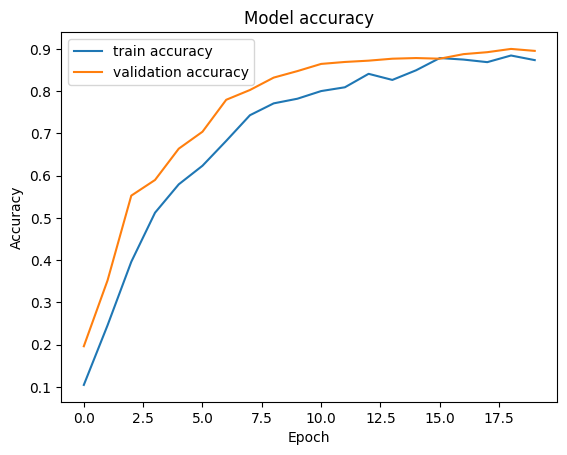

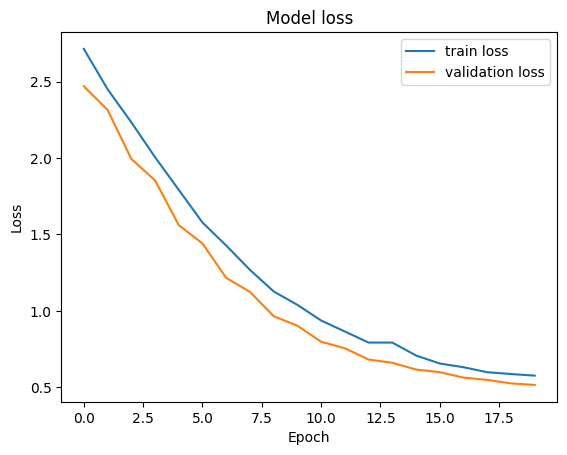

In [18]:
def plot_accuracy(history):

    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()

def plot_loss(history):

    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()

plot_accuracy(history)
plot_loss(history)

In [19]:
K.clear_session()
path_to_model='/kaggle/working/model_v1_inceptionV3.keras'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


In [20]:
test_data_dir = '/kaggle/working/dataset/test'

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 650 images belonging to 13 classes.


In [ ]:
scores = model.evaluate(test_generator, verbose=1)
print("Test Loss: {:.3f}".format(scores[0]))
print("Test Accuracy: {:.3f}".format(scores[1]))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.9408 - loss: 0.3996

In [26]:
# Definisikan nama kelas
class_names = ['Ayam Goreng', 'Burger', 'French Fries', 'Gado-Gado', 'Ikan Goreng',
               'Mie Goreng', 'Nasi Goreng', 'Nasi Padang', 'Pizza', 'Rawon',
               'Rendang', 'Sate', 'Soto']

# Mapping kategori
category = {i: [class_name, class_name] for i, class_name in enumerate(class_names)}

# Fungsi prediksi untuk satu gambar
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(299, 299))  # Sesuaikan ukuran jika perlu
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.0

    prediction = model.predict(img_processed)
    index = np.argmax(prediction)

    return index, prediction[0]

# Fungsi prediksi untuk seluruh folder test
def predict_all_classes(test_dir, model):
    accuracies = []  # Simpan akurasi setiap kelas
    class_labels = []  # Simpan nama kelas

    for class_name in sorted(os.listdir(test_dir)):  # Iterasi setiap kelas di folder test
        class_dir = os.path.join(test_dir, class_name)
        if not os.path.isdir(class_dir):  # Lewati jika bukan folder
            continue

        total_images = len(os.listdir(class_dir))
        correct_predictions = 0

        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)

            # Muat dan preprocess gambar
            img_ = image.load_img(img_path, target_size=(299, 299))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0)
            img_processed /= 255.0

            # Lakukan prediksi
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)
            predicted_label = category[index][0]

            # Bandingkan dengan label sebenarnya
            if predicted_label == class_name:
                correct_predictions += 1

        # Hitung akurasi untuk kelas ini
        acc = correct_predictions / total_images
        accuracies.append(acc)
        class_labels.append(class_name)
        print(f"Class: {class_name}, Accuracy: {acc:.2f} ({correct_predictions}/{total_images})")
    # Plot hasil akurasi
    plt.figure(figsize=(10, 6))
    bars = plt.barh(class_labels, accuracies, color='skyblue')
    plt.xlabel('Accuracy')
    plt.ylabel('Class')
    plt.title('Accuracy per Class')
    plt.xlim(0, 1)  # Akurasi berada pada rentang 0-1

    # Tambahkan angka akurasi di atas batang
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, f"{acc:.2f}",
                 va='center', ha='left', fontsize=10)

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

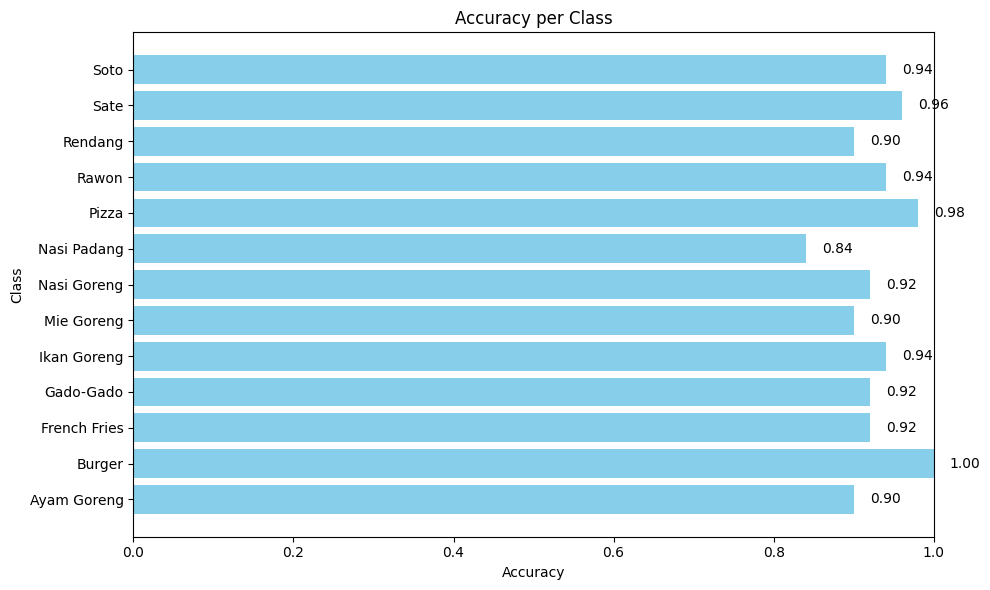

In [27]:
predict_all_classes('/kaggle/working/dataset/test', model)